### Importing the libraries

In [2]:
!pip install scikit-learn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder

print("Everything imported succesfully !")

ModuleNotFoundError: No module named 'sklearn'

In [2]:
# Let's load the data and explore it
df = pd.read_csv('data.csv')

### Exploratory data analysis ( Part 1 )

In [3]:
# Let's check the shape of the dataset
print("Shape of the dataframe : ",df.shape)

Shape of the dataframe :  (7927, 16)


In [4]:
# Let's check any 4 random rows from the dataset
df.sample(4)

,job_ID,job,location,company_id,company_name,work_type,full_time_remote,no_of_employ,no_of_application,posted_day_ago,alumni,Hiring_person,linkedin_followers,hiring_person_link,job_details,Column1
4018,3476926121,Open Position for Business Data Engineer,Greater Bengaluru Area,NaN,Luxoft,Hybrid,Full-time · Mid-Senior level,"10,001+ employees · IT Services and IT Consulting",27,8 hours,14 company alumni,Pooja Devi,NaN,https://www.linkedin.com/in/pooja-devi-19a5b3130,About the job Hi Greeting form Luxoft…!! Pleas...,NaN
1731,3471655650,"Software Engineer, Trilogy (Remote) - $200,000...","Dehradun, Uttarakhand, India",NaN,Crossover,Remote,Full-time · Mid-Senior level,"1,001-5,000 employees · IT Services and IT Con...",5,16 hours,12 company alumni,NaN,"5,399,177 followers",NaN,About the job Crossover is the world's #1 sour...,NaN
4156,3463098616,Doctoral Researcher,"Mangalagiri, Andhra Pradesh, India",NaN,"SRM University, AP",On-site,Full-time,"501-1,000 employees",days,4 days,NaN,Arghya Chakravarty,"23,086 followers",https://www.linkedin.com/in/arghya-chakravarty...,About the job SRM AP PhD Admissions 2023. @Asp...,NaN
5781,3402443332,Malware Analyst,"Mumbai, Maharashtra, India",NaN,MicroWorld Technologies Inc,NaN,Full-time,51-200 employees,135,5 days,NaN,MicroWorld eScan,"3,784 followers",https://www.linkedin.com/in/microworld-escan-8...,About the job Malware analysts are an importan...,NaN


**Observation**

Out of all the features job_id,company_id,hiring_person_link,hiring_person and Column1 features are unnecessary, so we will simply remove them

In [5]:
# Let's get some more basic infomraiton about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7927 entries, 0 to 7926
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   job_ID              7927 non-null   int64  
 1   job                 7894 non-null   object 
 2   location            7894 non-null   object 
 3   company_id          0 non-null      float64
 4   company_name        7892 non-null   object 
 5   work_type           7736 non-null   object 
 6   full_time_remote    7848 non-null   object 
 7   no_of_employ        7603 non-null   object 
 8   no_of_application   7887 non-null   object 
 9   posted_day_ago      7920 non-null   object 
 10  alumni              4858 non-null   object 
 11  Hiring_person       5720 non-null   object 
 12  linkedin_followers  4814 non-null   object 
 13  hiring_person_link  5720 non-null   object 
 14  job_details         7881 non-null   object 
 15  Column1             0 non-null      float64
dtypes: flo

In [6]:
# Checking if there are any duplicated values
print("Duplicate values : ",df.duplicated().sum())

Duplicate values :  79


job_ID                  0.000000
job                     0.416299
location                0.416299
company_id            100.000000
company_name            0.441529
work_type               2.409487
full_time_remote        0.996594
no_of_employ            4.087297
no_of_application       0.504605
posted_day_ago          0.088306
alumni                 38.715782
Hiring_person          27.841554
linkedin_followers     39.270846
hiring_person_link     27.841554
job_details             0.580295
Column1               100.000000
dtype: float64


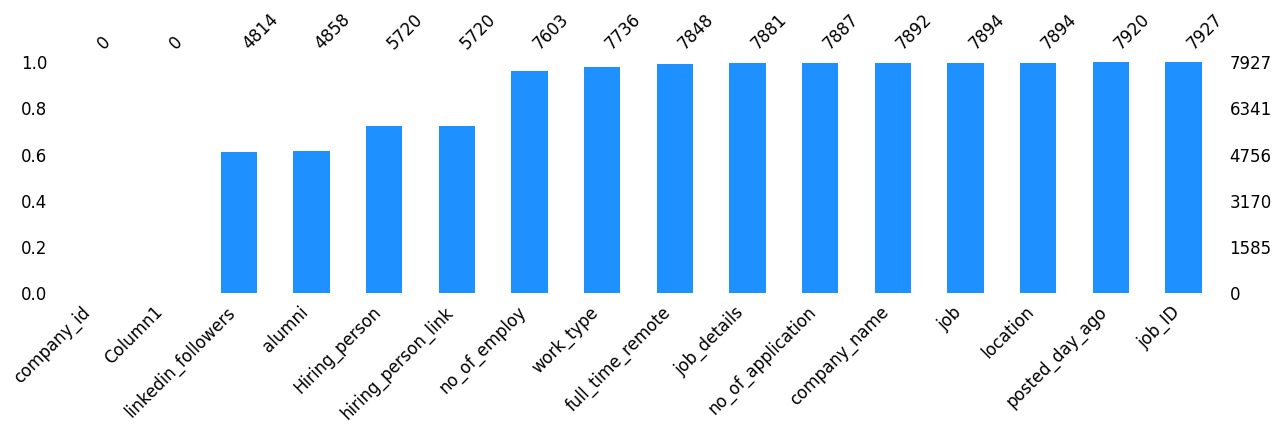

In [7]:
print(df.isnull().mean()*100)

# Visualize missing values using a bar chart
msno.bar(df,figsize = (15,3),color="dodgerblue", sort="ascending", fontsize=12)
plt.show()

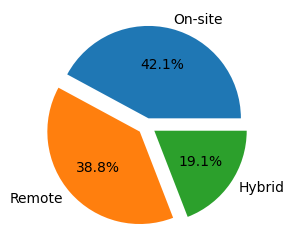

In [8]:
plt.figure(figsize=(3, 3))
ex = [0.08,0.1,0.1]
plt.pie(df['work_type'].value_counts(),labels = df['work_type'].value_counts().index,explode = ex,autopct='%1.1f%%')
plt.show()

### Data processing 

In [9]:
# Removing unnecessary columns from dataset
df.drop(['Column1','job_ID','company_id','hiring_person_link','Hiring_person'],axis = 1,inplace=True)

In [10]:
# Let's drop the duplicate values
df.drop_duplicates(inplace=True)
print("Total duplicate values : ",df.duplicated().sum())

Total duplicate values :  0


### Dealing with missing values ( Less than 5% )
Out of all the features presnent in our dataset there are few features in which the percentage of missing valeus is less 5%, so we will first take those features we will simply compare the change in distribution of such features after removing or imputing missing values using simple univariate techniques.

In [11]:
# Let's see all feature having less than 5% missing values
for cols in df.columns:
    if df[cols].isnull().mean()*100 < 5 and df[cols].isnull().mean()*100 > 0:
        print(cols)

job
location
company_name
work_type
full_time_remote
no_of_employ
no_of_application
posted_day_ago
job_details


Since all the above features are categorical in nature so we will simply use mode imputation.

In [18]:
cols = ['job','location','company_name','work_type','full_time_remote','no_of_employ',
        'no_of_application','posted_day_ago','job_details']

# Mode imputation
for col in cols:
    df[col] = df[col].fillna(df[col].mode()[0])

Now since both alumni and linkedin_followers have 38% and 39% missing values so we will be using some advance techniques to deal with missing values such as KNN imputer. But for using KNN imputer we need to make sure that our categorical data is properly encoded so we first need to encode our categorical features and also we will not be using job and job details feature in KNN imputer.

Also we need to fix some features so we will first fix the features and then we will encode categorical features and finally we will use KNN imputer.

### Feature engineering

In [24]:
# Function to extract the followers count from 'linkedin_followers' column
followers_count = []
for i in range(len(df)):
    row = df['linkedin_followers'].iloc[i]
    if pd.isnull(row):
        followers_count.append(np.nan)
    elif 'followers' not in row:
        followers_count.append(np.nan)
    else:
        followers = row.split(' ')[0]
        followers = followers.replace(',', '')
        followers = int(followers)
        followers_count.append(followers)

df.drop(['linkedin_followers'],axis=1,inplace=True)
df['followers_count_HM'] = pd.Series(followers_count)

In [27]:
Alumni_count = []
for i in range(len(df)):
    item = df['alumni'].iloc[i]
    if isinstance(item, int):
        Alumni_count.append(item)
    elif isinstance(item, float):
        Alumni_count.append(np.nan)
    elif isinstance(item, str):
        item = item.split(' ')[0]
        item = item.replace(',', '')
        Alumni_count.append(int(item))   

df.drop(['alumni'],axis=1,inplace=True)
df['Alumni_count'] = pd.Series(Alumni_count)

In [29]:
Number_Of_Emp = []
for i in range(len(df)):
    item = df['no_of_employ'].iloc[i]
    if isinstance(item, float):
        Number_Of_Emp.append(item)
    elif isinstance(item,str):
        item = item.split(' ')[0]
        item = item.replace(',','')
        Number_Of_Emp.append(item)

df.drop(['no_of_employ'],axis=1,inplace=True)
df['Number_Of_Emp'] = pd.Series(Number_Of_Emp)

In [32]:
# Replace 'hours', 'minutes', and 'seconds' with NaN
df['no_of_application'].replace(['hours', 'minute', 'seconds','minutes','hour'], np.nan, inplace=True)

# Rename the 'full_time_remote' column to 'Employment_type'
df.rename(columns={'full_time_remote': 'Employment_type'}, inplace=True)

In [36]:
Posted_Minutes_Ago = []
for i in range(len(df)):
    item = df['posted_day_ago'].iloc[i]
    if isinstance(item, float):
        Posted_Minutes_Ago.append(np.nan)
    elif isinstance(item, str) and item.split(' ')[1] == 'hours':
        Posted_Minutes_Ago.append(int(item.split(' ')[0]) * 60)
    elif isinstance(item, str) and item.split(' ')[1] == 'minutes':
        Posted_Minutes_Ago.append(int(item.split(' ')[0]))
    elif isinstance(item, str) and item.split(' ')[1] == 'seconds':
        Posted_Minutes_Ago.append(int(item.split(' ')[0]) / 60)

df.drop(['posted_day_ago'],axis=1,inplace=True)
df['Posted_Minutes_Ago'] = pd.Series(Posted_Minutes_Ago)

In [37]:
df.head(2)

,job,location,company_name,work_type,Employment_type,no_of_application,job_details,followers_count_HM,Alumni_count,Number_Of_Emp,Posted_Minutes_Ago
0,"Data Analyst, Trilogy (Remote) - $60,000/year USD","Delhi, Delhi, India",Crossover,Remote,Full-time · Associate,200,About the job Crossover is the world's #1 sour...,5395547.0,12.0,1001-5000,480.0
1,"Data Analyst, Trilogy (Remote) - $60,000/year USD","New Delhi, Delhi, India",Crossover,Remote,Full-time · Associate,184,About the job Crossover is the world's #1 sour...,5395547.0,12.0,1001-5000,480.0


In [38]:
print(df.isnull().mean()*100)

job                    0.000000
location               0.000000
company_name           0.000000
work_type              0.000000
Employment_type        0.000000
no_of_application     39.948751
job_details            0.000000
followers_count_HM    40.345932
Alumni_count          39.397822
Number_Of_Emp          1.434978
Posted_Minutes_Ago    38.744395
dtype: float64


In [24]:
for item in df['posted_day_ago']:
    if isinstance(str,str):
        
        print(item)
   

In [39]:
str = '30 hours'
int(str.split(' ')[0])/60

0.5

In [37]:
df['posted_day_ago'].unique() 

array(['8 hours', '9 hours', '7 hours', '26 minutes', '10 hours',
       '25 minutes', '9 minutes', '5 hours', '20 hours', '6 hours',
       '1 hour', '2 hours', '12 hours', '22 hours', '4 hours', '3 hours',
       '1 day', '23 hours', '37 minutes', '11 hours', '14 hours',
       '18 hours', '19 hours', '6 minutes', '21 hours', '13 hours',
       '8 minutes', '15 hours', '10 minutes', '4 days', '5 days',
       '2 days', '6 days', '1 minute', '11 minutes', '50 minutes',
       '13 minutes', '16 hours', '17 hours', '3 days', '25 seconds',
       '17 minutes', '12 minutes', '47 minutes', '7 minutes',
       '58 minutes', '56 minutes', '27 minutes', '53 minutes',
       '45 minutes', '4 minutes', '57 minutes', '1 week', nan,
       '43 minutes', '32 minutes', '52 minutes', '39 minutes',
       '5 minutes', '14 minutes', '16 minutes', '15 minutes',
       '18 minutes', '19 minutes', '20 minutes', '23 minutes',
       '22 minutes', '21 minutes', '24 minutes', '28 minutes',
       '29 minute

In [20]:
df.head(3)

,job,location,company_name,work_type,Employment_type,no_of_application,posted_day_ago,job_details,followers_count_HM,Alumni_count,Number_Of_Emp
0,"Data Analyst, Trilogy (Remote) - $60,000/year USD","Delhi, Delhi, India",Crossover,Remote,Full-time · Associate,200,8 hours,About the job Crossover is the world's #1 sour...,5395547.0,12.0,1001-5000
1,"Data Analyst, Trilogy (Remote) - $60,000/year USD","New Delhi, Delhi, India",Crossover,Remote,Full-time · Associate,184,8 hours,About the job Crossover is the world's #1 sour...,5395547.0,12.0,1001-5000
2,Data Analyst - WFH,Greater Bengaluru Area,Uplers,Remote,Full-time · Mid-Senior level,200,9 hours,About the job Profile: ML EngineersExperience:...,NaN,3.0,1001-5000


In [15]:
df['no_of_application'].unique()

array(['200', '184', '8', '2', '7', 'minutes', '22', '111', '36', '44',
       '29', '4', '19', '14', '13', '32', '20', 'hours', '5', '21', '27',
       '85', '97', '42', '3', '1', '130', '127', '11', '16', '60', '17',
       '52', '50', '10', '61', '95', '39', '18', '6', '40', '138', '9',
       '26', '78', '47', '104', '15', '110', '25', '38', '122', '34',
       '149', '83', '57', '66', '56', '80', '135', '158', '139', '54',
       '28', '23', '12', '175', '35', '87', '109', '71', '70', '24', '96',
       '48', '103', '31', 'days', 'minute', '68', '147', 'day', '46',
       '65', nan, '59', '102', '53', '125', '143', '142', '150', '195',
       '160', '99', '112', '67', '74', '134', '43', '98', '146', '55',
       '108', '115', '176', '113', '30', '126', '76', '72', '129', '100',
       '172', 'hour', '51', 'seconds', '79', '163', '41', '86', '69',
       '132', '114', '136', '148', '77', '117', '164', '90', '33', '63',
       '73', '81', '106', '75', '45', '82', '156', '173', '37',